L'option `remove=("headers", "footers", "quotes")` utilisée ci-dessous rend la tâche de classification plus difficile car le modèle ne peut pas "tricher" en regardant l'adresse email de l'expéditeur ou les en-têtes.


La [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) indique que par défaut `shuffle=True`, donc `random_state=21` permet une reproductibilité sur l'ordre des documents.

In [1]:
from sklearn.datasets import fetch_20newsgroups

data_train = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"), random_state=21)
train_label = data_train.target
data_test  = fetch_20newsgroups(subset="test",  remove=("headers","footers","quotes"), random_state=21)
test_label = data_test.target
len(data_train.data), len(data_test.data), len(test_label)

(11314, 7532, 7532)

Il y a 20 classes différentes :

In [2]:
import numpy as np
np.unique(test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [3]:
x_test = data_test.data
x_train = data_train.data
print(len(x_test))
print(len(x_train))

7532
11314


# **SVM linéaire**


On distingue deux grands types de SVM linéaires : le **Hard margin** SVM et le **Soft margin** SVM.

### SVM **Hard Margin**

Dans le premier, les instances doivent être parfaitement séparables par un hyperplan linéaire.

Les $x_i$ dans la classe $y_i = 1$ doivent satisfaire :
$$\omega^\top x_i + b \ge 1$$

Et les points $x_i$ dans la classe $y_i = -1$ doivent satisfaire :
$$\omega^\top x_i + b \le -1$$

On constate qu'un élément $x_i$ est bien classifié si $y_i$ et $(\omega^\top x_i + b)$ ont le même signe. Ainsi, on peut reformuler ces deux contraintes de manière unifiée :
$$\boxed{\forall i,\quad y_i \cdot (\omega^\top x_i + b) \ge 1}$$


Mais cela suppose que les données soient parfaitement linéairement séparables.

Si ce n'est pas le cas, alors, quel que soit l’hyperplan choisi, il existera au moins un point $x_i$ pour lequel $y_i \cdot (\omega^\top x_i + b) \le 0$ c’est-à-dire au moins un point mal classé (ce qui arrive si $y_i$ et $(\omega^\top x_i + b)$ ont des signes différents), ou situé sur la frontière de décision (ce qui arrive si $y_i \cdot (\omega^\top x_i + b) = 0$).

Formellement, c'est linéairement séparable si

$$\exists (\omega,b)\ \text{tel que}\ \forall i,\ y_i(\omega^\top x_i + b) > 0$$


et non linéairement séparable si :

$$\forall (\omega,b),\ \exists i\ \text{tel que}\ y_i(\omega^\top x_i + b) \le 0$$

### SVM **Soft Margin**

C'est ce pourquoi on utilise un **SVM linéaire soft margin** qui fonctionne même si les données ne sont pas parfaitement linéairement séparables en tolérant des écarts et donc des erreurs de classifications éventuelles.

De manière générale, dans un SVM, il faut maximiser l'espacement entre les deux marges (qui correspondent aux deux hyperplans $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = 1 \}$ et $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = -1 \}$). Mais, avec certaines données non linéairement séparables, il faut trouver un compromis entre la largeur de la marge et les erreurs de classification.

Dans un SVM soft margin, on associe à chaque point $x_i$ une quantité $\xi_i$ qui indique “de combien il manque” pour satisfaire la condition idéale $y_i(\omega^\top x_i + b) \ge 1$. Pour chaque point $x_i$, la quantité $\xi_i$ est donnée par :

$$\xi_i = \max(0, 1 - y_i (\omega^\top x_i + b))$$

Il y a trois cas possibles (bien classé, dans la marge, mal classé) :

* Si le point $x_i$ est bien classé :

$$
y_i (\omega^\top x_i + b) \ge 1
\quad\Rightarrow\quad
\big[1 - y_i (\omega^\top x_i + b)\big] \le 0
\quad\Rightarrow\quad
\xi_i = 0
$$

* Si le point $x_i$ est dans la marge (entre les deux hyperplans) mais correctement classé :

$$
0 < y_i (\omega^\top x_i + b) < 1
\quad\Rightarrow\quad
0 < \xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] < 1
$$

* Si le point $x_i$ est mal classé :

$$
y_i (\omega^\top x_i + b) < 0
\quad\Rightarrow\quad
\xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] > 1
$$

Maintenant, on peut pénaliser le modèle à la fois en fonction du nombre de points du mauvais côté (en comptant à la fois les points dans les marges bien classés et ceux qui sont mal classés) et de l'ampleur des violations (plus la position d'un point s'écarte de sa position attendue, plus la pénalité sur la loss sera forte).

### **Comparaison de [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et de [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)**

Dans `LinearSVC` de Scikitlearn, on peut régler le compromis entre la largeur de la marge et les erreurs sur l’échantillon grâce à l'hyperparamètre $C$.

Si $C$ est grand, on cherche à réduire au maximum ces erreurs quitte à avoir une marge plus petite ; si $C$ est petit, on tolère davantage les violations pour favoriser une marge plus large.

`SGDClassifier` regroupe plusieurs classifieurs linéaires dont les poids sont optimisés par descente de gradients. Lorsqu'on règle `loss='hinge'`, c'est un SVM linéaire.

Dans `SGDClassifier` l'hyperparamètre "alpha" joue un rôle équivalent au paramètre $C$ de `LinearSVC`.




## **Quel optimiseur d'hyperparamètres choisir ?**

On présente ci-dessous trois méthodes pour rechercher les hyperparamètres optimaux :

### 1. **GridSearch**
**[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)** effectue une recherche ***exhaustive*** : il teste *toutes* les combinaisons possibles dans des grilles d'hyperparamètres prédéfinies.
Bien qu'on ait la garantie de trouver l'optimum global dans l'espace discret prédéfini, le temps et le coût computationnel peuvent vite devenir très élevés en fonction de la taille de l'espace des valeurs possibles.

### 2. **RandomizedSearchCV**

Au lieu d’essayer toutes les combinaisons possibles de paramètres,
[`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) choisit ***au hasard*** un certain nombre (prédéfini) de combinaisons de paramètres. Il évalue chacune de ces combinaisons avec une validation croisée. Puis, finalement, il retient la combinaison qui donne les meilleurs résultats. On trouve sur le site de Scikitlearn [un code qui emploie cette méthode](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py) pour trouver les hyperparamètres optimaux d'un classifieur Naive Bayes sur le même dataset qu'ici (20newsgroups).

### 3. **Optuna**
**[`Optuna`](https://pypi.org/project/optuna/)** utilise une recherche ***bayésienne*** (algorithme TPE - Tree-structured Parzen Estimator) en échantillonnant l'espace des hyperparamètres et en privilégiant les régions prometteuses identifiées par les évaluations précédentes. Cela permet d'obtenir de bonnes solutions avec moins d'itérations. C'est pas absolument nécessaire ici mais dans certains cas où les espaces d'hyperparamètres à tester sont de très grande dimension et continus c'est plus rapide et efficace.

# **Méthodologie**

Puisqu'on ne sait pas trop quoi choisir entre [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et  [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), nous allons tester une optimisation des hyperparamètres avec les deux dans la section 3.

Pour que ce soit vraiment comparable, on va essayer de faire vraiment l'équivalent des deux côtés.

Mais avant cela, il faut procéder à une étape de vectorisation.

## **Vectorisation avec TF-IDF**

#### **Suppression des stop-words**

Scikit-learn possède un fichier interne qui contient une liste fixe de mots anglais considérés comme des `stop_words` . Comme ils le font dans les codes proposé sur leur site (par exemple [ce code](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) ou encore [ce code](https://scikit-learn.org/0.21/auto_examples/text/plot_document_classification_20newsgroups.html)), on enlève les `stop_words` présents dans le corpus. On peut afficher le nombre de ces `stop_words` et les inspecter manuellement avec :

```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(len(ENGLISH_STOP_WORDS))
print(list(ENGLISH_STOP_WORDS))
```

Commençons par computer toutes les matrices TF-IDF qui vont être utilisées, de manière à éviter de les re-calculer. La cellule qui suit prend quelques minutes à s'executer et prend un certain espace dans la RAM, mais elle permettra de gagner du temps lors des étapes d'optimisation des hyperparamètres juste après.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from itertools import product
import numpy as np

# Valeurs discrètes pour le cache
MAX_FEATURES_VALUES = [10000, 15000, 20000, 25000, 30000]
MAX_DF_VALUES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def precompute_tfidf(texts_train, texts_test, max_feats, max_df_vals, n_jobs=-1):
    """
    Pré-calcule les matrices TF-IDF pour les 5*6 = 30 combinaisons
    Stocke aussi le vectorizer pour transformer les données de test.
    """
    def fit(mf, mdf):
        vec = TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=mf,
            max_df=mdf,
            dtype=np.float32
        )
        X_train = vec.fit_transform(texts_train)
        X_test = vec.transform(texts_test)
        return (mf, mdf), {
            'vectorizer': vec,
            'X_train': X_train,
            'X_test': X_test
        }

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit)(mf, mdf)
        for mf, mdf in product(max_feats, max_df_vals)
    )
    return dict(results)

# Pré-calcul (exécuté une seule fois)
print(f"Pré-calcul de {len(MAX_FEATURES_VALUES) * len(MAX_DF_VALUES)} matrices TF-IDF")
tfidf_cache = precompute_tfidf(
    x_train, x_test,
    MAX_FEATURES_VALUES,
    MAX_DF_VALUES
)
print(f"Cache créé avec {len(tfidf_cache)} entrées.")

Pré-calcul de 30 matrices TF-IDF
Cache créé avec 30 entrées.


Précaution méthodologique : en principe les vecteurs TF-IDF doivent être calculés seulement sur les "plis d'entraînement" (training folds) et être appliqué sur le "pli de validation" (validation fold).

Il faudra ensuite prendre les résultats des optimisations qui suivent avec précaution, car la façon dont on procède risque de gonfler très légèrement les scores.

Mais l'approche par cache est plus économique computationnellement (et donc plus rapide ici). On constatera l'écart de performance avec l'ensemble "test" ultérieurement.

In [5]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.3 MB/s eta 0:00:00


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import optuna
import time

def create_objective_fast_cached(y, tfidf_cache, cv=3):
    """Réutilisation du cache TF-IDF pré-calculé."""
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        alpha = trial.suggest_float('alpha', 1e-4, 1e-2, log=True)

        # Récupération de la matrice pré-calculée (économie de compute !)
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = SGDClassifier(
            loss='hinge',
            alpha=alpha,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Mesure du temps d'exécution
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_fast_cached(y, tfidf_cache, n_trials=30, cv=3):
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
    )
    objective = create_objective_fast_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_sgd = run_optuna_fast_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[SGDClassifier] Meilleurs paramètres : {study_sgd.best_params}")
print(f"[SGDClassifier] Meilleur score CV : {study_sgd.best_value:.4f}")
print("\n[Importance des hyperparamètres]")

importances = optuna.importance.get_param_importances(study_sgd)
for param, importance in importances.items():
    print(f"{param} : {importance:.4f}")

[I 2025-12-14 18:03:54,223] A new study created in memory with name: no-name-4adb7804-6446-4b93-88fd-af013a57a6b0


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 18:03:55,771] Trial 0 finished with value: 0.7168108386836005 and parameters: {'max_features': 15000, 'max_df': 0.7, 'alpha': 0.008706020878304856}. Best is trial 0 with value: 0.7168108386836005.
[I 2025-12-14 18:03:57,683] Trial 1 finished with value: 0.7146892683170546 and parameters: {'max_features': 10000, 'max_df': 0.8, 'alpha': 0.0005404103854647331}. Best is trial 0 with value: 0.7168108386836005.
[I 2025-12-14 18:04:00,075] Trial 2 finished with value: 0.7170759265961446 and parameters: {'max_features': 15000, 'max_df': 1.0, 'alpha': 0.004138040112561018}. Best is trial 2 with value: 0.7170759265961446.
[I 2025-12-14 18:04:01,456] Trial 3 finished with value: 0.7223792315056422 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.001096821720752952}. Best is trial 3 with value: 0.7223792315056422.
[I 2025-12-14 18:04:03,038] Trial 4 finished with value: 0.7296266394229782 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.0004473636174

/tmp/ipython-input-303084656.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_sgd)
/tmp/ipython-input-303084656.py:5: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_sgd, params=["max_features"])


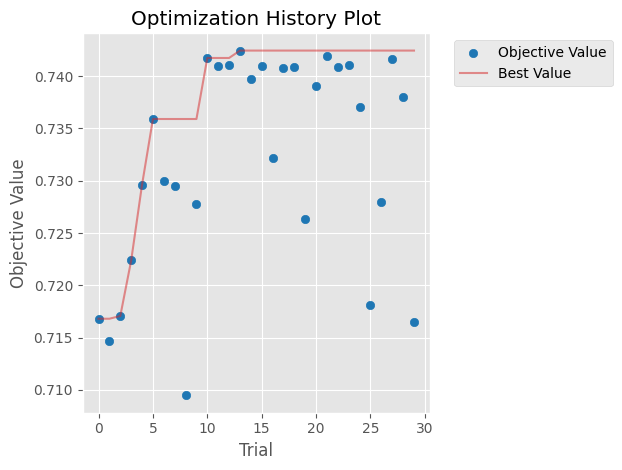

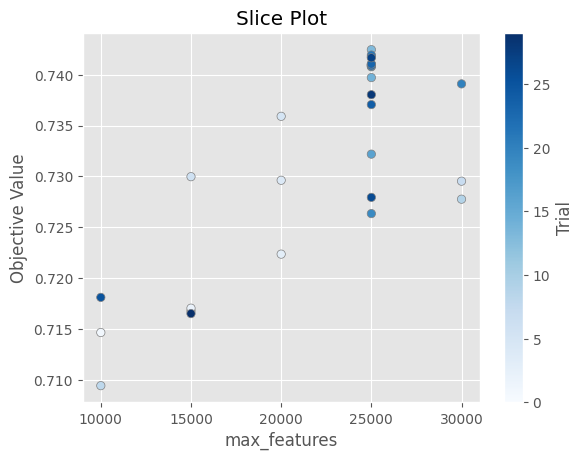

In [7]:
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt

vis_mpl.plot_optimization_history(study_sgd)
vis_mpl.plot_slice(study_sgd, params=["max_features"])
plt.show()

In [8]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier

best_params = study_sgd.best_params
best_mf = best_params['max_features']
best_mdf = best_params['max_df']
best_alpha = best_params['alpha']

# Retrouver les matrices TF-IDF dans le cache
cached_data = tfidf_cache[(best_mf, best_mdf)]
X_train_transformed = cached_data['X_train']
X_test_transformed = cached_data['X_test']

final_clf = SGDClassifier(
    loss='hinge',
    alpha=best_alpha,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

# Tester les performances du modèle sur l'ensemble "test"
final_clf.fit(X_train_transformed, train_label)
y_pred = final_clf.predict(X_test_transformed)
final_accuracy = accuracy_score(test_label, y_pred)

print(f"Précision (accuracy) sur le test : {final_accuracy:.4f}")
print(classification_report(test_label, y_pred, target_names=data_test.target_names, digits=3))

Précision (accuracy) sur le test : 0.6840
                          precision    recall  f1-score   support

             alt.atheism      0.507     0.473     0.489       319
           comp.graphics      0.666     0.702     0.683       389
 comp.os.ms-windows.misc      0.620     0.624     0.622       394
comp.sys.ibm.pc.hardware      0.652     0.645     0.649       392
   comp.sys.mac.hardware      0.734     0.709     0.721       385
          comp.windows.x      0.796     0.711     0.751       395
            misc.forsale      0.744     0.777     0.760       390
               rec.autos      0.748     0.674     0.709       396
         rec.motorcycles      0.775     0.744     0.759       398
      rec.sport.baseball      0.833     0.778     0.805       397
        rec.sport.hockey      0.549     0.920     0.687       399
               sci.crypt      0.826     0.694     0.754       396
         sci.electronics      0.633     0.552     0.590       393
                 sci.med      0.7

On va faire la même chose avec `LinearSVC`.

Pour cela, on utilise une formule qui donne une équivalence entre l'hyperparamètre $C$ de LinearSVC et l'hyperparamètre $alpha$ de SGCDClassifier :

$$
alpha = \frac{1}{n_{samples} × C}
$$

Source : [User Guide de ScikitLearn](https://scikit-learn.org/stable/modules/linear_model.html#comparison-with-the-regularization-parameter-of-svm)

In [9]:
n_samples = len(x_train)
alpha_min = 1e-4
alpha_max = 1e-2

# Application de la formule
c_max_equivalent = 1 / (n_samples * alpha_min)
c_min_equivalent = 1 / (n_samples * alpha_max)

print(f"Pour alpha={alpha_max} C équivalent ≈ {c_min_equivalent:.5f}")
print(f"Pour alpha={alpha_min} C équivalent ≈ {c_max_equivalent:.5f}")

Pour alpha=0.01 C équivalent ≈ 0.00884
Pour alpha=0.0001 C équivalent ≈ 0.88386


In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import optuna
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt
import time

def create_objective_large_cached(y, tfidf_cache, cv=5):
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        C = trial.suggest_float('C', 0.01, 0.88, log=True)

        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = LinearSVC(
            C=C,
            loss='hinge',
            dual=True,
            max_iter=2000,
            tol=1e-4,
            random_state=42
        )

        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score
    return objective

def run_optuna_large_cached(y, tfidf_cache, n_trials=40, cv=4):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    objective = create_objective_large_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_large = run_optuna_large_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[LinearSVC] Meilleurs paramètres : {study_large.best_params}")
print(f"[LinearSVC] Meilleur score CV : {study_large.best_value:.4f}")
print("\n[Importance des hyperparamètres]")
importances = optuna.importance.get_param_importances(study_large)
for param, importance in importances.items():
    print(f"{param} : {importance:.4f}")

[I 2025-12-14 18:04:55,558] A new study created in memory with name: no-name-dddd87a0-3810-40e0-b630-af30bb2a3ba9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 18:05:21,422] Trial 0 finished with value: 0.737139256078312 and parameters: {'max_features': 15000, 'max_df': 0.7, 'C': 0.8114298978297201}. Best is trial 0 with value: 0.737139256078312.
[I 2025-12-14 18:05:27,631] Trial 1 finished with value: 0.7126559857167356 and parameters: {'max_features': 10000, 'max_df': 0.8, 'C': 0.05262317427124475}. Best is trial 0 with value: 0.737139256078312.
[I 2025-12-14 18:05:39,342] Trial 2 finished with value: 0.7359019447998427 and parameters: {'max_features': 15000, 'max_df': 1.0, 'C': 0.39022617359903367}. Best is trial 0 with value: 0.737139256078312.
[I 2025-12-14 18:05:49,781] Trial 3 finished with value: 0.7304222270053092 and parameters: {'max_features': 20000, 'max_df': 0.7, 'C': 0.10561972485086042}. Best is trial 0 with value: 0.737139256078312.
[I 2025-12-14 18:05:54,402] Trial 4 finished with value: 0.7283008362569328 and parameters: {'max_features': 20000, 'max_df': 0.7, 'C': 0.04369253157486055}. Best is trial 0 with val

/tmp/ipython-input-2379190173.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_large)
/tmp/ipython-input-2379190173.py:4: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_large, params=["max_features"])


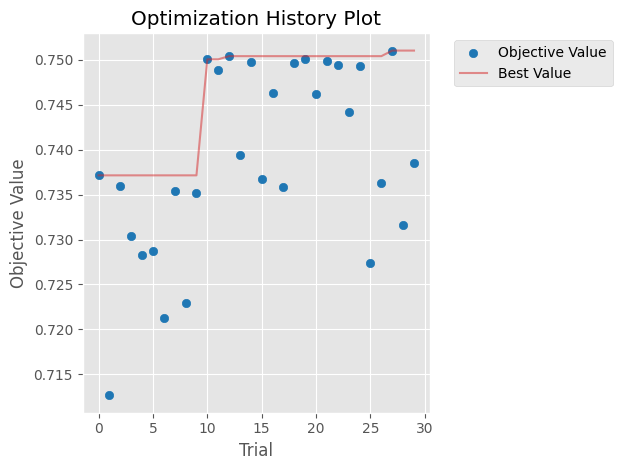

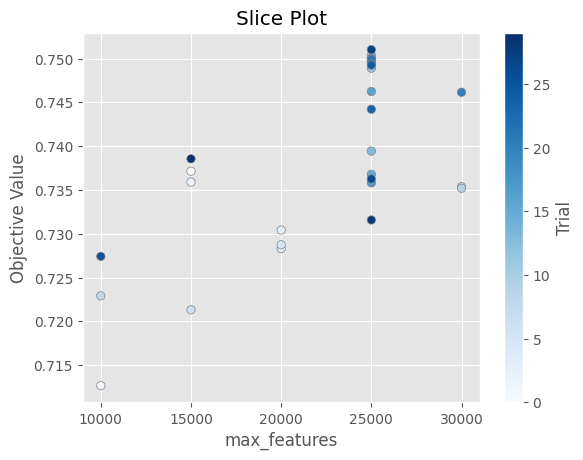

In [11]:
# Visualisations

vis_mpl.plot_optimization_history(study_large)
vis_mpl.plot_slice(study_large, params=["max_features"])
plt.show()

In [12]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier

best_params = study_large.best_params
best_mf = best_params['max_features']
best_mdf = best_params['max_df']
best_C = best_params['C']

# Récupérer les matrices TF-IDF dans le cache
cached_data = tfidf_cache[(best_mf, best_mdf)]
X_train_transformed = cached_data['X_train']
X_test_transformed = cached_data['X_test']

final_clf = LinearSVC(
    C=best_C,
    max_iter=1500,
    tol=1e-4,
    dual=True,
    random_state=42
)

# Tester les performances du modèle sur l'ensemble "test"
final_clf.fit(X_train_transformed, train_label)
y_pred = final_clf.predict(X_test_transformed)
final_accuracy = accuracy_score(test_label, y_pred)

print(f"Précision (accuracy) sur le test : {final_accuracy:.4f}")
print(classification_report(test_label, y_pred, target_names=data_test.target_names, digits=3))

Précision (accuracy) sur le test : 0.6839
                          precision    recall  f1-score   support

             alt.atheism      0.531     0.483     0.506       319
           comp.graphics      0.652     0.717     0.683       389
 comp.os.ms-windows.misc      0.615     0.624     0.620       394
comp.sys.ibm.pc.hardware      0.632     0.643     0.637       392
   comp.sys.mac.hardware      0.724     0.688     0.706       385
          comp.windows.x      0.809     0.696     0.748       395
            misc.forsale      0.751     0.787     0.768       390
               rec.autos      0.727     0.687     0.706       396
         rec.motorcycles      0.751     0.741     0.746       398
      rec.sport.baseball      0.538     0.829     0.652       397
        rec.sport.hockey      0.868     0.870     0.869       399
               sci.crypt      0.831     0.694     0.757       396
         sci.electronics      0.637     0.580     0.607       393
                 sci.med      0.7

## **Résultats**

### Sur la performance

Le troisième graphique suggère que plus la dimensionalité des vecteurs TF-IDF est grande (plus l'hyperparamètre `max_features` est élevé), plus la performance est élevée.
Par induction, on peut supposer qu'augmenter encore `max_features` aura pour effet d'augmenter également la performance du modèle.

### Sur la différence entre `LinearSVC` et `SGDClassifier`

Au global, dans cette optimisation des hyperparamètres, la méthode `LinearSVC` prend un tout petit peu plus de temps que la méthode `SGDClassifier`.  De plus, il semble qu'elle arrive généralement à une performance très très légèrement meilleure.

Puisqu'on vient de sauvegarder tous les temps d'éxécution, on peut faire une régression pour voir quels sont les hyperparamètres qui influencent le plus le temps d'éxécution.

### **Quel paramètre influence le plus le temps d'éxécution ?**

In [13]:
from sklearn.ensemble import RandomForestRegressor
import polars as pl

def analyze_duration_importance(study, features, name):
    """Analyse de l'impact des features sur le temps d'exécution."""
    df = pl.DataFrame([
        t.params | {'duration': t.user_attrs['duration']}
        for t in study.trials if t.state.name == "COMPLETE"
    ])

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[features], df["duration"])

    importance = sorted(
        zip(features, rf.feature_importances_.tolist()),
        key=lambda x: x[1],
        reverse=True
    )
    print(f"\n Influence des features sur le temps d'exécution avec {name}:")
    for feat, imp in importance:
        print(f"  {feat}: {imp:.4f}")

# Analyse pour les deux études
analyze_duration_importance(study_sgd, ["max_features", "max_df", "alpha"], "SGDClassifier")
analyze_duration_importance(study_large, ["max_features", "max_df", "C"], "LinearSVC")


 Influence des features sur le temps d'exécution avec SGDClassifier:
  alpha: 0.7080
  max_features: 0.1662
  max_df: 0.1258

 Influence des features sur le temps d'exécution avec LinearSVC:
  C: 0.5918
  max_features: 0.2364
  max_df: 0.1718


Ces résultats corroborent certaines de nos expériences dans lesquelles, lorsqu'on lançait un trial `LinearSVC` avec une valeur de $C$ élevée, cela prenait très longtemps à converger ou bien cela ne convergeait pas.

### **Pistes expérimentales : retirer certains éléments ? Fusionner certaines catégories ?**

##### **Sur la catégorie `talk.religion.misc`**

Il semble que certaines catégories qui finissent par “misc” soient particulièrement difficiles à classer. [Un article de blog](https://galileo.ai/blog/improving-your-ml-datasets-with-galileo-part-1) montre par exemple que `talk.religion.misc` est fréquemment confondue avec `alt.atheism` et `soc.religion.christian` même par des gros modèles ([exemple](https://github.com/vggls/text_classification_fetch_20newsgroups/blob/main/nlp_ntbk_(fetch_20newsgroups_classification).ipynb)). Dans nos tests avec SVM comme dans beaucoup [d'autres proposés sur internet](https://www.kaggle.com/code/balatmak/text-classification-pipeline-newsgroups20), c'est la catégorie sur laquelle il y a les pires performances.


Il semble que c'est parce que la classe `talk.religion.misc` chevauche les catégories ` alt.atheism` et `soc.religion.christian` . Ils proposent [une version "arrangée" du dataset 20newsgroups](https://huggingface.co/datasets/galileo-ai/20_Newsgroups_Fixed) qui enlève les éléments confusants et ambigus afin de réduire le chevauchement inter-catégories.


##### **Sur la catégorie `comp.os.ms-windows.misc`**


Dans [un code qui vise à faire un clustering](https://scikit-learn.ru/1.4/auto_examples/bicluster/plot_bicluster_newsgroups.html#:~:text=Vectorizing,measure%3A%200.3015) proposé sur le site de Scikitlearn, ils excluent la catégorie `comp.os.ms-windows.misc`.
Dans ce qui suit, on teste la même chose juste pour voir s'il y a une amélioration significative (ou pas) de la performance du SVM.


In [14]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc",
]

data_train = fetch_20newsgroups(categories=categories, subset="train", remove=("headers","footers","quotes"), random_state=21)
train_label = data_train.target


data_test  = fetch_20newsgroups(categories=categories, subset="test",  remove=("headers","footers","quotes"), random_state=21)
test_label = data_test.target

np.unique(test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [16]:
train_label_filtered = data_train.target
test_label_filtered = data_test.target

from sklearn.pipeline import Pipeline

pipeline_filtered = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=40000)),
    ('clf', LinearSVC(loss='hinge', C=0.4, dual=True, max_iter=1500, random_state=42))
])

print("Entraînement sur le dataset filtré (sans 'comp.os.ms-windows.misc')")
pipeline_filtered.fit(data_train.data, train_label_filtered)
acc = pipeline_filtered.score(data_test.data, test_label_filtered)

print(f"Accuracy sur le dataset filtré : {acc:.4f}")
# À comparer avec l'accuracy précédente

Entraînement sur le dataset filtré (sans 'comp.os.ms-windows.misc')
Accuracy sur le dataset filtré : 0.7071


Tester un entraînement avec `class_weight='balanced'` pour voir si cela donne de meilleures performances car il y a de légers déséquilibres dans ce jeu de données.